# **Practical Example 4**
## **Multiple Object Detection with RetinaNet**


## Imports

In [1]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
    
print(tf.__version__)

2.7.0


## Implementing utility *functions*

In [2]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

## Computing pairwise Intersection Over Union (IOU)

In [3]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, figsize=(5, 5), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    
    # convert coners to xywh
    boxes = convert_to_xywh(boxes)
    
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x, y, w, h = box
        patch = plt.Rectangle(
            [x, y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x,
            y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

## Implementing Anchor generator


In [4]:

class AnchorBox:

    def __init__(self):
        self.aspect_ratios = [0.75, 1.0, 1.25]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):

        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):

        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):

        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

## Preprocessing data


In [5]:
def preprocess_data(image, label):

    bbox = tf.cast(label[:, :4], dtype=tf.float32)
    class_id = tf.cast(tf.argmax(label[:, 4:4+3], axis=-1), dtype=tf.int32)
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    
    bbox = tf.stack(
        [
            bbox[:, 0],
            bbox[:, 1],
            bbox[:, 2],
            bbox[:, 3],
        ],
        axis=-1,
    )
    
    return image, bbox, class_id

## Encoding labels

In [6]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):

        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):

        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        return batch_images, labels.stack()

## Building the ResNet50 backbone


In [7]:
def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3], weights='imagenet'
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    
    backbone = keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )
    
    backbone.trainable = False
    
    return backbone

## Building Feature Pyramid Network (FPN) as a custom layer

In [8]:
class FeaturePyramid(keras.layers.Layer):

    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

## Building the classification and box regression heads.

In [9]:
def build_head(output_filters, bias_init):

    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

## Building RetinaNet using a subclassed model

In [10]:
class RetinaNet(keras.Model):

    def __init__(self, num_classes, backbone=None, **kwargs):
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

## Implementing a custom layer to decode predictions

In [11]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=3,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

## Implementing Smooth L1 loss and Focal Loss as keras custom losses

In [12]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=3, num_objects=2, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes
        self._num_objects = num_objects
    
    def call(self, y_true, y_pred):
        
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]

        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
        loss = clf_loss + box_loss
        
        return loss

## Setting up training parameters

In [13]:
model_dir = "retinanet_mod/"
label_encoder = LabelEncoder()

num_classes = 3
num_objects = 3
batch_size = 16

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

## Initializing and compiling model

In [14]:
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

94781440/94765736 [==============================] - 1s 0us/step


## Setting up callbacks

In [15]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

## Implementing utility *dataset functions*

In [16]:
!apt install libcairo2-dev
!pip install pycairo
import cairo

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

def multiple_shape_dataset(num_imgs = 100, num_objects = 2, img_size = 32, min_object_size = 4, max_object_size = 16):
  bboxes = np.zeros((num_imgs, num_objects, 4))
  imgs = np.zeros((num_imgs, img_size, img_size, 4), dtype=np.uint8)  # format: BGRA
  shapes = np.zeros((num_imgs, num_objects), dtype=int)
  colors = np.zeros((num_imgs, num_objects), dtype=int)

  num_shapes = 3
  shape_labels = ['rectangle', 'circle', 'triangle']

  for i_img in range(num_imgs):
    # cairo
    surface = cairo.ImageSurface.create_for_data(imgs[i_img], cairo.FORMAT_ARGB32, img_size, img_size)
    cr = cairo.Context(surface)

    # Fill background white.
    cr.set_source_rgb(1, 1, 1)
    cr.paint()

    # Draw random shapes.
    for i_object in range(num_objects):
      shape = np.random.randint(num_shapes)
      shapes[i_img, i_object] = shape

      if shape == 0:  # rectangle
          w, h = np.random.randint(min_object_size, max_object_size, size=2)
          x = np.random.randint(0, img_size - w)
          y = np.random.randint(0, img_size - h)
          bboxes[i_img, i_object] = [x, y, w, h]
          cr.rectangle(x, y, w, h)            
          cr.set_source_rgb(0.5, 0.1, 0.1) # red
        
      elif shape == 1:  # circle   
          r = 0.5 * np.random.randint(min_object_size, max_object_size)
          x = np.random.randint(r, img_size - r)
          y = np.random.randint(r, img_size - r)
          bboxes[i_img, i_object] = [x - r, y - r, 2 * r, 2 * r]
          cr.arc(x, y, r, 0, 2*np.pi)
          cr.set_source_rgb(0.1, 0.5, 0.1) # green
        
      elif shape == 2:  # triangle
          w, h = np.random.randint(min_object_size, max_object_size, size=2)
          x = np.random.randint(0, img_size - w)
          y = np.random.randint(0, img_size - h)
          bboxes[i_img, i_object] = [x, y, w, h]
        
          cr.move_to(x, y)
          cr.line_to(x+w, y)
          cr.line_to(x+w, y+h)
          cr.line_to(x, y)
          cr.close_path()
          cr.set_source_rgb(0.1, 0.1, 0.5) # blue

      cr.fill()

  imgs = imgs[..., 2::-1]  # is BGRA, convert to RGB

  return imgs, bboxes, shapes, shape_labels

def one_encoding_dataset(imgs, bboxes, shapes, num_objects = 3, num_shapes = 3):
  num_imgs = imgs.shape[0]
  img_size = imgs[0].shape[0]

  shapes_onehot = np.zeros((num_imgs, num_objects, num_shapes))
  for i_img in range(num_imgs):
      for i_object in range(num_objects):
          shapes_onehot[i_img, i_object, shapes[i_img, i_object]] = 1
          
  y = np.concatenate([bboxes, shapes_onehot], axis=-1).reshape(num_imgs, num_objects, -1) # num_imgs, num_objects, 4 (bbox) + num_classes
    
  return imgs, y

def split_dataset(X, y):
  num_imgs = X.shape[0]
  i = int(0.8 * num_imgs)
  train_X = X[:i]
  test_X = X[i:]
  train_y = y[:i]
  test_y = y[i:]
  return train_X, test_X, train_y, test_y

def split_imgs(imgs, bboxes):
  num_imgs = imgs.shape[0]
  i = int(0.8 * num_imgs)
  test_imgs = imgs[i:]
  test_bboxes = bboxes[i:]
  return test_imgs, test_bboxes

def show_image(img, bbox, shape, shape_labels):
  img_size = imgs[0].shape[0]
  plt.imshow(img, interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
  for b, s in zip(bbox, shape):
      plt.gca().add_patch(matplotlib.patches.Rectangle((b[0], b[1]), b[2], b[3], ec='k', fc='none'))
      plt.annotate(shape_labels[s], (b[0], b[1] + b[3] + 0.7), clip_on=False)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libpixman-1-dev libxcb-shm0-dev
0 upgraded, 4 newly installed, 0 to remove and 37 not upgraded.
Need to get 930 kB of archives.
After this operation, 3,986 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcairo-script-interpreter2 amd64 1.15.10-2ubuntu0.1 [53.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpixman-1-dev amd64 0.34.0-2 [244 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxcb-shm0-dev amd64 1.13-2~ubuntu18.04 [6,684 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcairo2-dev amd64 1.15.10-2ubuntu0.1 [626 kB]
Fetched 

## Create dataset

In [17]:
imgs, bboxes, shapes, shape_labels = multiple_shape_dataset(num_imgs=800, num_objects=num_objects,img_size = 128, min_object_size = 16, max_object_size = 32)
X, y = one_encoding_dataset(imgs, bboxes, shapes, num_objects=num_objects)
train_X, test_X, train_y, test_y = split_dataset(X, y)

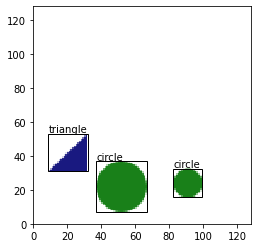

In [18]:
show_image(imgs[1], bboxes[1], shapes[1], shape_labels)

In [19]:
# train_y[0].shape
# train_y[0][:, :4].shape, train_y[0][:, 4:]
# y = train_y[0].reshape(2, -1)
# box = y[:, :4]
# class_prob = y[:, 4:4+3]
# train_y[0].shape, y.shape, box.shape, class_prob

In [20]:
# https://www.pyimagesearch.com/2021/06/14/a-gentle-introduction-to-tf-data-with-tensorflow/
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y))

# version tersonflow
try:
    autotune = tf.data.AUTOTUNE     
except:
    autotune = tf.data.experimental.AUTOTUNE 

train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(batch_size=batch_size, drop_remainder=False)

train_dataset = train_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(batch_size=1, drop_remainder=False)

val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

## Training the model

In [ ]:
epochs = 25

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    # callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/25
40/40 [==============================] - 233s 6s/step - loss: 3.2399 - val_loss: 3.3609
Epoch 2/25
40/40 [==============================] - 221s 6s/step - loss: 3.2377 - val_loss: 3.3586
Epoch 3/25
40/40 [==============================] - 225s 6s/step - loss: 3.2353 - val_loss: 3.3562
Epoch 4/25
40/40 [==============================] - 224s 6s/step - loss: 2.9634 - val_loss: 2.7018
Epoch 5/25
40/40 [==============================] - 224s 6s/step - loss: 2.3599 - val_loss: 2.3296
Epoch 6/25
40/40 [==============================] - 225s 6s/step - loss: 1.9533 - val_loss: 1.9143
Epoch 7/25
40/40 [==============================] - 225s 6s/step - loss: 1.6826 - val_loss: 1.6070
Epoch 8/25
40/40 [==============================] - 225s 6s/step - loss: 1.2231 - val_loss: 1.0242
Epoch 9/25
40/40 [==============================] - 226s 6s/step - loss: 0.8144 - val_loss: 0.7848
Epoch 10/25
40/40 [==============================] - 227s 6s/step - loss: 0.6471 - val_loss: 0.6743
Epoch 11/

## Building inference model

In [ ]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.45)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

## Generating detections

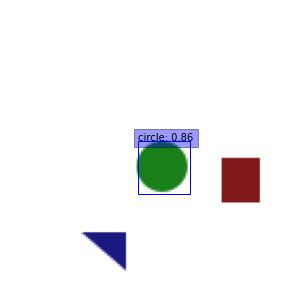

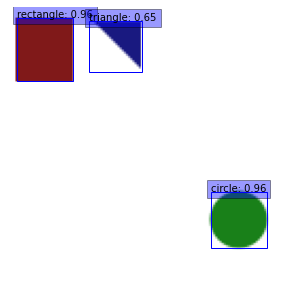

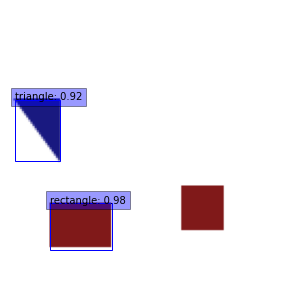

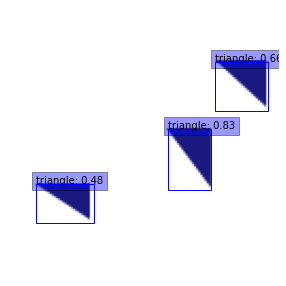

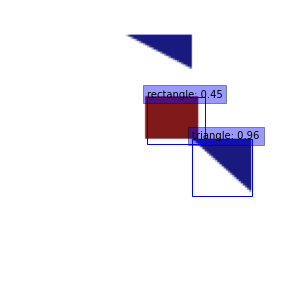

In [ ]:
for sample in val_dataset.take(5):
        
        image = tf.cast(sample[0], dtype=tf.float32)
        
        # image shape = batch_size, dimension, dimension, 3
        detections = inference_model.predict(image)

        num_detections = detections.valid_detections[0]
        # print(num_detections)
        
        # show image
        image = tf.squeeze(sample[0])
        
        class_names = [
            shape_labels[int(x)] for x in detections.nmsed_classes[0][:num_detections]
        ]
        
        bbox = detections.nmsed_boxes[0][:num_detections]
        scores = detections.nmsed_scores[0][:num_detections]
        
        #show bbox and labels
        visualize_detections(
            image,
            bbox,
            class_names,
            scores,
        )